In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

In [4]:
#Experiment parameters
NUM_DATASETS = 50       # number of random datasets to generate (for averaging results)
NOISE_VARIANCE = 0.5    # variance of Gaussian noise added to sine data
MAX_POLY = 12           # maximum polynomial degree to test
N = 25                  # number of data points in each dataset
Ntrain = int(0.9*N)     # training set size (90% of data)

np.random.seed(2)       # reproducibility

In [5]:
# Helper function: polynomial feature expansion
def make_poly(x, D):
  """
  Given input vector x, create polynomial features up to degree D.
  Columns: [x^0, x^1, ..., x^D]
  For degrees > 1, standardize each column (zero mean, unit variance).
  """
  N = len(x)
  X = np.empty((N, D+1))
  for d in range(D+1):
    X[:,d] = x**d
    if d > 1:  # standardize higher-order terms
      X[:,d] = (X[:,d] - X[:,d].mean()) / X[:,d].std()
  return X

# True function: sine wave
def f(X):
  return np.sin(X)

In [ ]:
# Generate "true" curve for plotting
x_axis = np.linspace(-np.pi, np.pi, 100)
y_axis = f(x_axis)

In [ ]:
# Generate one dataset (inputs shuffled)
X = np.linspace(-np.pi, np.pi, N)
np.random.shuffle(X)   # shuffle to randomize train/test split
f_X = f(X)             # true outputs without noise

# Precompute polynomial features for maximum degree
Xpoly = make_poly(X, MAX_POLY)  

In [ ]:
# Storage arrays for results
train_scores = np.zeros((NUM_DATASETS, MAX_POLY))       # training MSE
test_scores = np.zeros((NUM_DATASETS, MAX_POLY))        # test MSE
train_predictions = np.zeros((Ntrain, NUM_DATASETS, MAX_POLY))  # predictions on train set
prediction_curves = np.zeros((100, NUM_DATASETS, MAX_POLY))      # predictions on full curve

In [ ]:
# Model: simple linear regression
model = LinearRegression()

In [ ]:
# Main experiment loop
for k in range(NUM_DATASETS):
  # Add Gaussian noise to sine outputs
  Y = f_X + np.random.randn(N)*NOISE_VARIANCE

  # Split into train/test
  Xtrain = Xpoly[:Ntrain]
  Ytrain = Y[:Ntrain]
  Xtest = Xpoly[Ntrain:]
  Ytest = Y[Ntrain:]

  # Try polynomial fits of increasing degree
  for d in range(MAX_POLY):
    # Fit model using polynomial features up to degree d+1
    model.fit(Xtrain[:,:d+2], Ytrain)
    predictions = model.predict(Xpoly[:,:d+2])

    # Predict on smooth axis for visualization
    x_axis_poly = make_poly(x_axis, d+1)
    prediction_axis = model.predict(x_axis_poly)
    prediction_curves[:,k,d] = prediction_axis

    # Separate train/test predictions
    train_prediction = predictions[:Ntrain]
    test_prediction = predictions[Ntrain:]

    # Store train predictions (for bias/variance calc later)
    train_predictions[:,k,d] = train_prediction

    # Compute mean squared error
    train_score = mse(train_prediction, Ytrain)
    test_score = mse(test_prediction, Ytest)

    train_scores[k,d] = train_score
    test_scores[k,d] = test_score

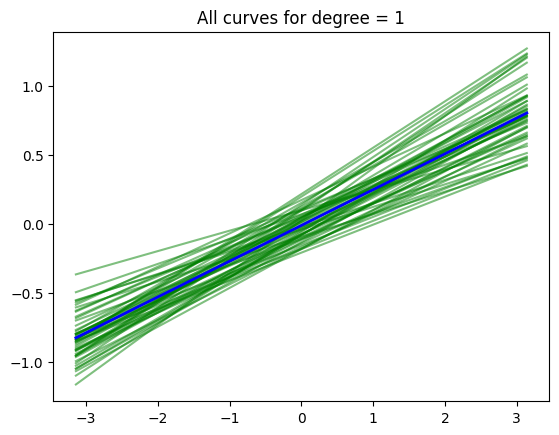

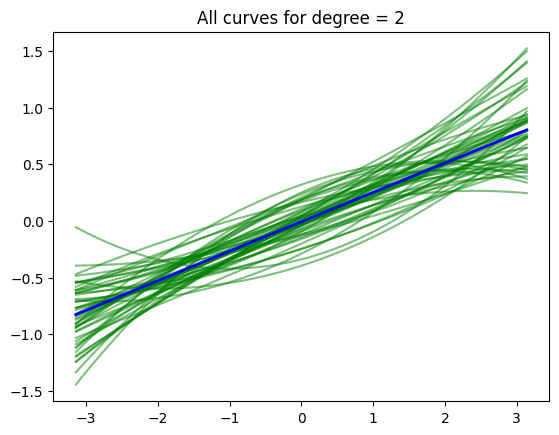

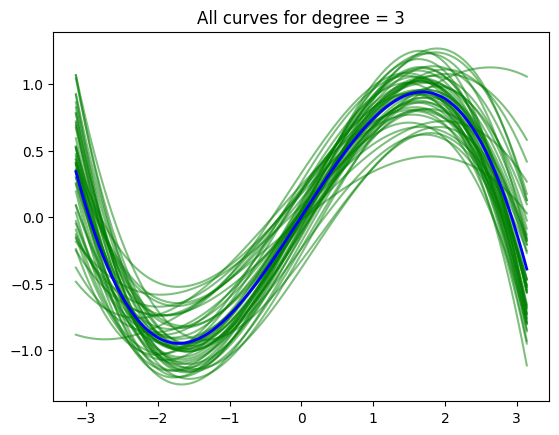

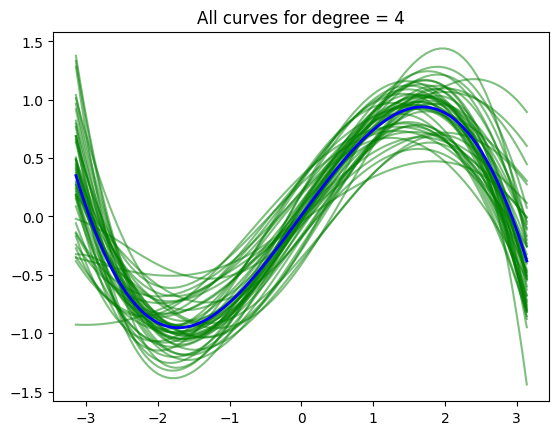

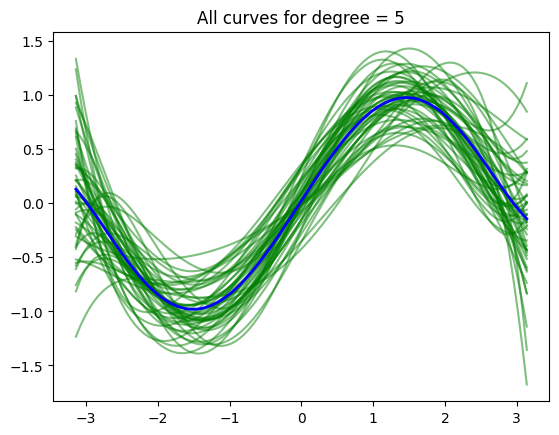

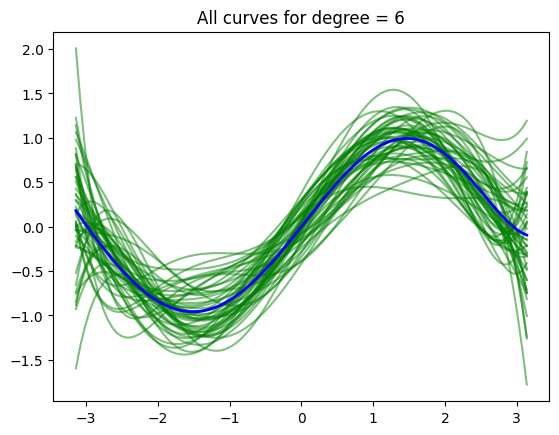

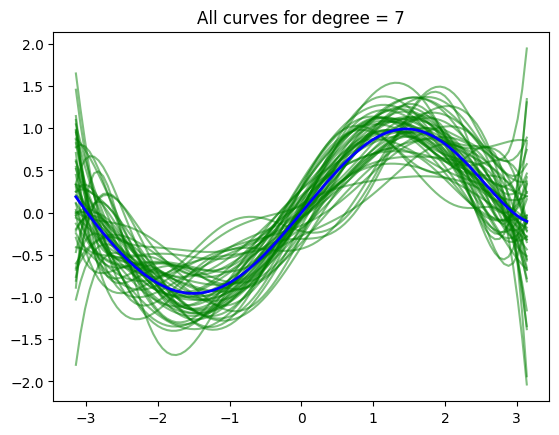

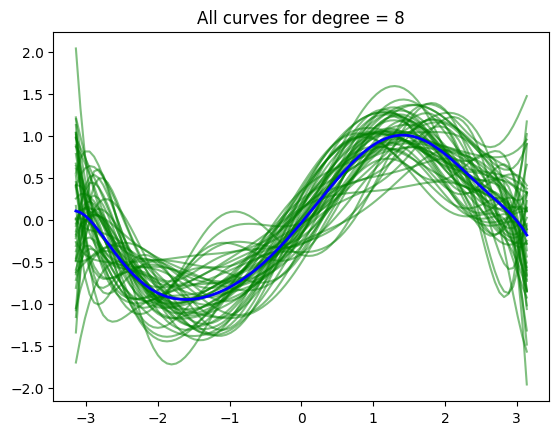

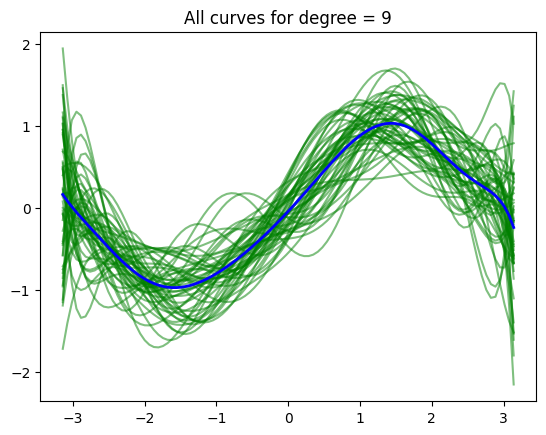

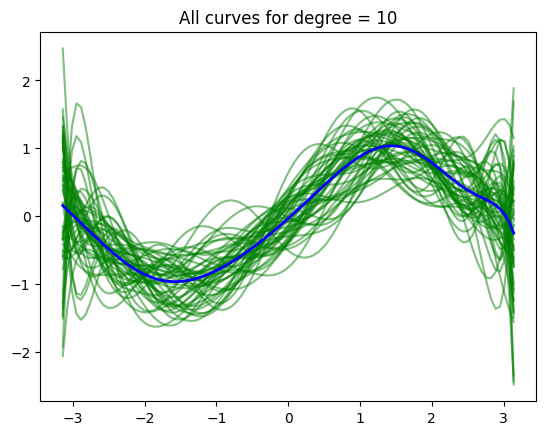

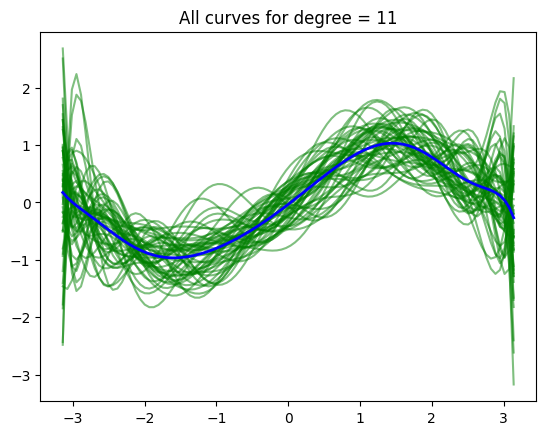

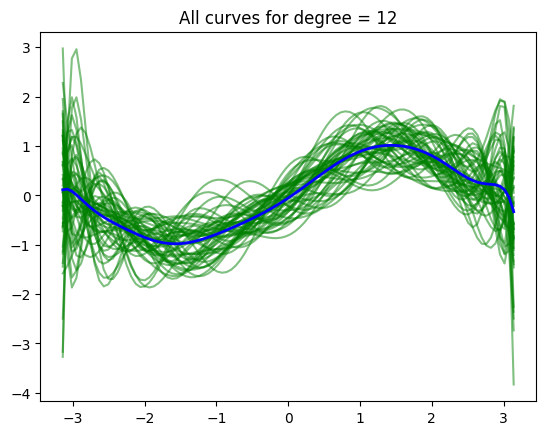

In [ ]:
# Visualization: prediction curves
for d in range(MAX_POLY):
  # Plot all curves for this degree (green, semi-transparent)
  for k in range(NUM_DATASETS):
    plt.plot(x_axis, prediction_curves[:,k,d], color='green', alpha=0.5)
  # Plot mean curve across datasets (blue, bold)
  plt.plot(x_axis, prediction_curves[:,:,d].mean(axis=1), color='blue', linewidth=2.0)
  plt.title("All curves for degree = %d" % (d+1))
  plt.show()

In [ ]:
# Bias calculation
avg_train_prediction = np.zeros((Ntrain, MAX_POLY))
squared_bias = np.zeros(MAX_POLY)
f_Xtrain = f_X[:Ntrain]   # true outputs (no noise) for training set

for d in range(MAX_POLY):
  for i in range(Ntrain):
    # Average prediction across datasets
    avg_train_prediction[i,d] = train_predictions[i,:,d].mean()
  # Squared bias = mean squared difference between average prediction and true function
  squared_bias[d] = ((avg_train_prediction[:,d] - f_Xtrain)**2).mean()

In [ ]:
# Variance calculation
variances = np.zeros((Ntrain, MAX_POLY))
for d in range(MAX_POLY):
  for i in range(Ntrain):
    delta = train_predictions[i,:,d] - avg_train_prediction[i,d]
    variances[i,d] = delta.dot(delta) / len(delta)
variance = variances.mean(axis=0)

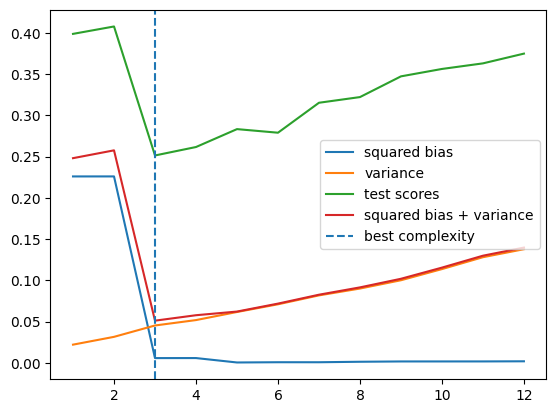

In [ ]:
# Bias-Variance tradeoff plots
degrees = np.arange(MAX_POLY) + 1
best_degree = np.argmin(test_scores.mean(axis=0)) + 1  # degree with lowest avg test error

plt.plot(degrees, squared_bias, label='squared bias')
plt.plot(degrees, variance, label='variance')
plt.plot(degrees, test_scores.mean(axis=0), label='test scores')
plt.plot(degrees, squared_bias + variance, label='squared bias + variance')
plt.axvline(x=best_degree, linestyle='--', label='best complexity')
plt.legend()
plt.show()

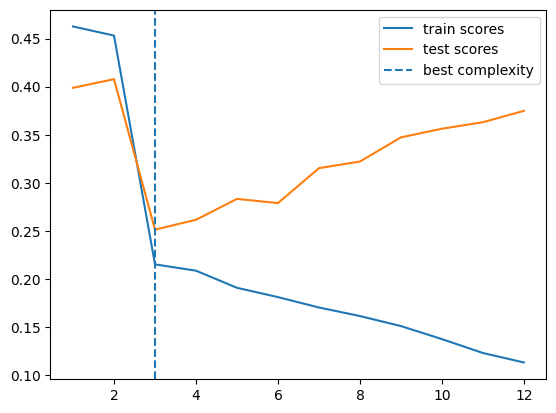

In [ ]:
# Train vs Test error plot
plt.plot(degrees, train_scores.mean(axis=0), label='train scores')
plt.plot(degrees, test_scores.mean(axis=0), label='test scores')
plt.axvline(x=best_degree, linestyle='--', label='best complexity')
plt.legend()
plt.show()